# Naive Bayes

- supervised algorithm


- classification based on conditional probabilities:


**$P(A|B)$**    **probability of event A, knowing that event B has already occured**


- finding a conditional probability:

$$ P(A|B)=\frac{P(B|A) * P(A)}{P(B)} \quad (1.1) $$
 

**"probabilty for event a, if event B has occured is the multiplication of probability for event B, if event A has occured times probability for event A divided by probability for event B"**






### Example card deck:

What is the probability to draw a queen, if you know you will draw a diamon?

- cards in total: 52
- diamonds: 13
- queens: 4


$$P(queen|diamond) = \frac{P(diamond|queen)\cdot P(queen)}{P(diamond)} \quad (1.2) $$




- P(diamond|queen): 1/4 (Probability to have diamond if you have a queen)



- P(Queen): 1/4



- P(diamond): 1/13 





- or:

$$ P(y|X)=\frac{P(X|y)\cdot P(y)}{P(X)} \quad (1.3) $$ 

- **X - Feature-Vector** 



- **y- Label-Vektor**

### assumption: all features are mutually independent 


- with this assumption we cann apply the chain rule on (1.3)



- P(y|X) is called **posterior probability**



- P(X|y) is called **Classconditional probability**




- P(y) is called **prior probablity of y**; simply the **frequency**



- P(X) is called **prior probablity of X**



$$ P(y|X)=\frac{P(x_1|y)\cdot P(x_2|y)...\cdot P(x_n|y)\cdot P(y)}{P(X)} \quad (1.4)$$ 

### select class with highest probability

$$ y = argmax_yP(y|X) = argmax_y \frac{P(x_1|y) \cdot P(x_2|y) \cdot ... \cdot P(x_n|y) * P(y)}{P(X)} \quad (1.5) $$

- **P(X) irrelevant**; so we receive from (1.5):

$$ y = argmax_yP(x_1|y) \cdot P(x_2|y) \cdot P(y) \quad (1.6) $$ 

- problem: as every probability lays between 0 and 1 (1.6) would produce a very small number; to counteract this, we use the logarithm, change multiplikation into summation and receive (1.7)

$$ y=argmax_y log(P(x_1|y))+log(P(x_2|y))+...+log(P(x_n|y))+log(P(y)) \quad (1.7) $$

### Modeling the classconditional probability $P(x_i|y)$

- using **Gaussian Distribution** for this

$$ P(x_i|y)=\frac{1}{\sqrt{2 \cdot \pi \cdot \sigma_y^2}} \cdot \exp{-\frac{(x_i-\mu_y)^2}{2\sigma_y^2}} \quad (1.8) $$

## Algorithm Summary

### Training
- 1) get all **unique classes** of the training data



- 2) extract the **submatrix of features** for each 



- 3) for each submatrix, calculate for each **feature** the **mean and variance**. 



- 4) for each unique class, calculate its **probability** based on its occurence in the training data


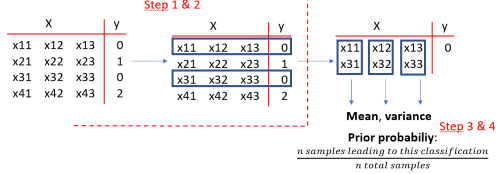



## Prediction

- 1) take the feature values of a given sample & calculate the class probability according to (1.8) for each


- 2) add it to the given probabilites for each training sample


- 3) get the index of the class that has the highest probability. this will be the classification class

In [41]:
import numpy as np
from math import pi


class NaiveBayes:
    
    # doesn't need an init()-method
    def __init__(self):
        pass
    
# EXPLANATION FOR FIT METHOD
    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        
        # get every unique class in the training-label vector y & get the amount of them
        self.unique_classes = np.unique(y)
        self.n_unique_classes = len(self.unique_classes)
        
        
        # initialize mean, variance, priors
                
        # for each unique class we calculate a mean & and variance for each feature column
        self.mean = np.zeros((self.n_unique_classes, self.n_features))
        self.var = np.zeros((self.n_unique_classes, self.n_features))
        
        # for each unique class we want one prior
        self.prior_probabilities = np.zeros(self.n_unique_classes)
        
        # loop over all unique classes and calculate their according
        # 1) featurecolumn-mean
        # 2) featurecolumn-variance 
        # 3) the probability for this class
        for unique_class in self.unique_classes:
            
            # first, create a submatrix (X_crop), containing for each unique class the according feature rows
            X_crop_giving_this_class = X[y == unique_class]
            
            # 1) for each feature column of the submatrix, calculate the mean feature value leading to this classification
            self.mean[unique_class, :] = X_crop_giving_this_class.mean(axis = 0)
            
            # 2) for each feature column of the submatrix, calculate the variance of the feature value, 
            # leading to this classification
            self.var[unique_class, :] = X_crop_giving_this_class.var(axis = 0)
            
            # 3) calculate the prior probability for this class by dividing the amount samples leading to the current
            # classification, divided by the total amount of samples
            self.prior_probabilities[unique_class] = X_crop_giving_this_class.shape[0] / self.n_samples

    
    # function to apply the prediction after fitting. it is possible to give the prediction method 
    # a feature vector with > 1 feature row, that means to perform more than one prediction at once
    def predict(self, X):
        
        # extract each feature row of the feature vector and perform a prediction for each seperately;
        y_hat = [self._predict(x) for x in X]
        return y_hat 
    
    
    # helperfunction to apply (1.7)
    def _predict(self, x):
        posterior_probabilities = []
        
        # loop over every unique class of the training data 
        for index, unique_class in enumerate(self.unique_classes):
            
            # extract the current class probability
            prior_probability = np.log(self.prior_probabilities[index])
            
            # apply (1.7) using a helperfunction to calculate the class probabilites. this will return 
            # a vector of class conditionals
            class_conditional_array = np.log(self.calculate_class_conditional_probability(index, x))
            
            # (1.7) requires to sum all of the class conditionals up
            class_conditional = np.sum(class_conditional_array)
            
            # calculate the probability for each unique class based on the current feature row and append it to a list
            posterior_probability  = prior_probability + class_conditional
            posterior_probabilities.append(posterior_probability)
        
        # apply the argmax-function to find out the index of the highest probability and get the class at this index
        y_hat = self.unique_classes[np.argmax(posterior_probabilities)]
            
        return y_hat
            
    # helperfunction to apply (1.8)
    def calculate_class_conditional_probability(self, class_index, x):
        
        # extract the mean & var at the given class index
        mean = self.mean[class_index]
        var = self.var[class_index]
        
        # apply (1.8)
        class_conditional_probability = (1 / (np.sqrt(2 * pi * var))) * np.exp(-((x - mean) **2) / (2 * var **2))
        
        return class_conditional_probability
        
        
    # helperfunction to calculate the accuracy of the trained model from y_hat and y_test data
    def calculate_accuracy(self, y_hat, y_test):
        
        # accuracy is the sum of all correct classifications, divided by the total amount of classifications
        accuracy = np.sum(y_hat == y_test) / len(y_test)
        
        return accuracy

## Test our model

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt




X, y = datasets.make_classification(n_samples = 1000, n_features = 10, n_classes = 2, random_state = 123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)



naive_bayes_classifier = NaiveBayes()
naive_bayes_classifier.fit(X_train, y_train)
y_hat = naive_bayes_classifier.predict(X_test)


accuracy = naive_bayes_classifier.calculate_accuracy(y_hat, y_test)
print(accuracy)



0.975
